In [8]:
from brian2 import *


In [50]:
def run_sim(RNECK):
    start_scope()

    # Set the default time step
    defaultclock.dt = 0.01*ms

    # Base Params

    gK = 36*msiemens/cm**2
    VK = -90. * mV
    V_reset = -70. * mV
    thres = 'v > 0*mV'
    ref = 'v > -10*mV'
    gl = 0.3*msiemens/cm**2
    El = -70*mV
    Cm=1*uF/cm**2 # specific membrane capacitance
    Ri=100*ohm*cm # intracellular resistivity


    # -----------------------------
    # Model Equations
    # -----------------------------

    eqs = '''
    Im = gl * (El-v) + v_prev * g : amp/meter**2
    v_prev : volt
    I : amp (point current)
    g : siemens/meter**2
    '''

    eqs_neck = '''
    Im = gl * (El-v) + v_prev * g + gK * (VK - v) : amp/meter**2
    v_prev : volt
    I : amp (point current)
    g : siemens/meter**2
    gK : siemens/meter**2
    '''

    eqs_head = '''
    Im = gl * (El-v): amp/meter**2
    I : amp (point current)
    g : siemens/meter**2
    gK : siemens/meter**2
    '''

    # Morphology Parameters
    d_spine_head = 0.4 # um
    l_spine_neck = 0.4 # um
    d_spine_neck = 0.1 # um

    d_soma = 30 # um
    d_dendrite = 1 # um
    l_dendrite = 100 # um


    # Create a morphology
    soma_morph = Soma(diameter = d_soma*um)
    soma_morph.dendrite = Cylinder(diameter = d_dendrite*um, length = l_dendrite*um, n = 5)
    neck_morph = Cylinder(diameter = d_spine_neck*um, length = l_spine_neck*um, n = 5)
    head_morph = Soma(diameter = d_spine_head*um)

    # Generate the neurons
    soma = SpatialNeuron(morphology=soma_morph, model=eqs, Cm=Cm, Ri=100*ohm*cm, threshold = thres, threshold_location=0, refractory = ref)
    neck = SpatialNeuron(morphology=neck_morph, model=eqs_neck, Cm=Cm, Ri=RNECK)
    head = SpatialNeuron(morphology=head_morph, model=eqs_head, Cm=Cm, Ri=100*ohm*cm)

    # Initial System Setup
    head.v = V_reset
    neck.v = V_reset
    soma.v = V_reset

    # This is a conductance that I use when 'connecting' the voltages at between the spatial neurons. 
    # The actual value is somewhat arbitrary.
    neck.g = 3*siemens/meter**2
    head.g = 3*siemens/meter**2
    soma.g = 3*siemens/meter**2

    # Set a constant gK for the spine neck
    neck.gK = 1*siemens/meter**2

    @network_operation
    def f(t):
        neck[4].v_prev = head.v
        soma[5].v_prev= neck[0].v


    #M_soma = StateMonitor(soma, ['v', 'I'], record=True)
    M_spine_head = StateMonitor(head, ['v', 'Im'], record=True)
    M_spine_neck = StateMonitor(neck, ['v', 'v_prev', 'Im'], record=True)
    M_soma = StateMonitor(soma, ['v', 'Im'], record = True)

    # Starting the simulation

    run(10*ms)
    head.I = 1 * nA # send an electric pulse
    run(0.02*ms)
    head.I = 0 * nA
    run(10*ms)

    return M_spine_head, M_spine_neck, M_soma


# Testing to see if the simulation works. R_neck is the same. gK is constant at 1 S/m^2

Plotted below are the voltages over time for the simulation at 10 ms. The head+neck and soma+dendrite are plotted separately. Note that the dendrite and soma both have 5 compartments.

In [51]:
M_spine_head, M_spine_neck, M_soma = run_sim(100*ohm*cm)

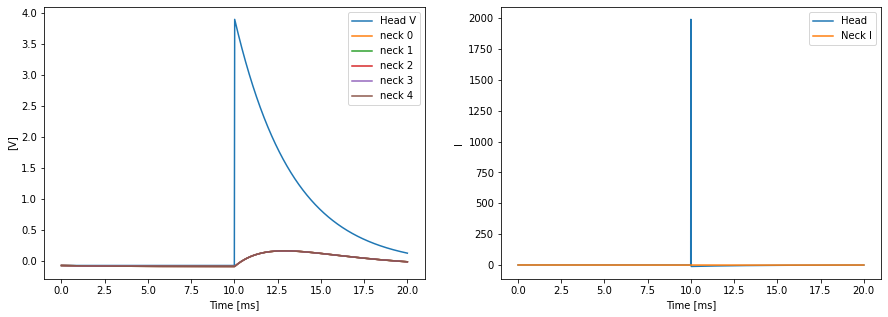

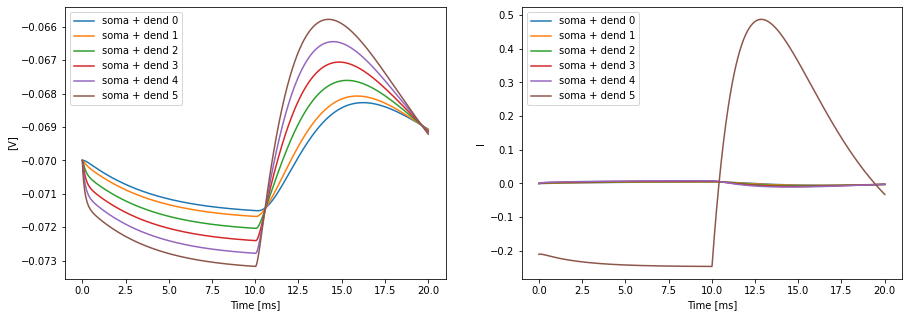

In [52]:
fig, axs = plt.subplots(1,2, figsize = (15,5))
axs[0].plot(M_spine_head.t/ms, M_spine_head.v[0], label = 'Head V')
for idx, item in enumerate(M_spine_neck):
    axs[0].plot(item.t/ms, item.v, label = 'neck ' + str(idx))
axs[0].legend()
axs[0].set_xlabel('Time [ms]')
axs[0].set_ylabel('[V]')

axs[1].plot(M_spine_head.t/ms, M_spine_head.Im[0], label = 'Head')
axs[1].plot(M_spine_neck.t/ms, M_spine_neck.Im[0], label = 'Neck I')    
axs[1].set_xlabel('Time [ms]')
axs[1].set_ylabel('I')
axs[1].legend()

fig, axs = plt.subplots(1,2, figsize = (15,5))
for idx, item in enumerate(M_soma):
    axs[0].plot(M_soma.t/ms, item.v, label = 'soma + dend ' + str(idx))
    axs[1].plot(M_soma.t/ms, item.Im, label = 'soma + dend ' + str(idx))
axs[0].legend()
axs[0].set_xlabel('Time [ms]')
axs[0].set_ylabel('[V]')
axs[1].set_xlabel('Time [ms]')
axs[1].set_ylabel('I')
axs[1].legend()

In [61]:
def EPSP(monitor):
    t = monitor.t/ms
    v = monitor.v/mV
    return np.max(v) - v[np.where(t<10)[0][-1]]

Text(0.5, 1.0, 'EPSP at the Soma')

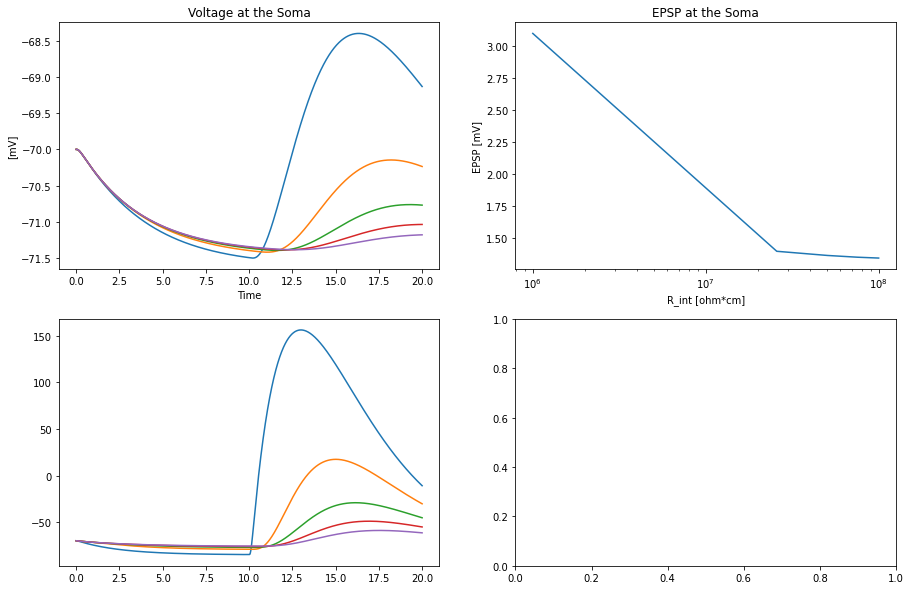

In [65]:
R_VALS = np.linspace(1e6, 1e8, 5)
EPSPs = np.zeros(len(R_VALS))

fig, axs = plt.subplots(2,2, figsize = (15, 10))

for idx,r in enumerate(R_VALS):
    M_spine_head, M_spine_neck, M_soma = run_sim(r*ohm*cm)
    axs[0][0].plot(M_soma[0].t/ms, M_soma[0].v/mV, label = "R_neck = " + str(r))
    axs[1][0].plot(M_spine_neck[0].t/ms, M_spine_neck[0].v/mV, label = "R_neck = " + str(r))

    EPSPs[idx] = EPSP(M_soma[0])

axs[0][1].plot(R_VALS, EPSPs)
axs[0][1].set_xscale('log')

axs[0][0].set_ylabel("[mV]")
axs[0][0].set_xlabel("Time")
axs[0][0].set_title("Voltage at the Soma")
axs[0][1].set_ylabel("EPSP [mV]")
axs[0][1].set_xlabel("R_int [ohm*cm]")
axs[0][1].set_title("EPSP at the Soma")

In [ ]:
fig